In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import datetime
import re
from os.path import expanduser


# Get libertine font
from matplotlib.font_manager import _rebuild; _rebuild()
import matplotlib.font_manager as font_manager
# ??plt.use('Agg')
fontpath = expanduser('~/Library/Fonts/LinLibertine_R.otf')
print('fontpath', fontpath)
prop = font_manager.FontProperties(fname=fontpath)
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams['text.usetex'] = False

print(len(font_manager.findSystemFonts()))

%matplotlib inline

fontpath /Users/fboemer/Library/Fonts/LinLibertine_R.otf
216


In [9]:
def parse_results(file_name):
    re_time = r'.*Total time (.*) \(ms\)'
    runtime = None
    with open(file_name) as f:
        lines = [line.strip() for line in f.readlines()]
        for line in lines:
            #print(line)
            if re.match(re_time, line):
                match = re.match(re_time, line)
                runtime = float(match.groups()[0])
                break
            
    if runtime is None:
        print('No runtime fouund in ', file_name)
    assert(runtime is not None)
    
    return runtime


In [44]:
folder = './results/'
best_times = []


num_threads = [1, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112]
thread_runtimes = {}
for nt in num_threads:
    thread_runtimes[nt] = []

omp1_times = []
naive_times = []
for i in range(1,11):
    naive_file = folder + 'naive_recsaling_' + str(i) + '.txt'
    naive_time = parse_results(naive_file)
    naive_times.append(naive_time)
    
for nt in num_threads:
    for i in range(1,11):
        filename = folder + 'best_nt' + str(nt) + '_' + str(i) + '.txt'
        runtime = parse_results(filename)
        thread_runtimes[nt].append(runtime)
    
def fmt_rescaling_line(times):
    batch_size = 4096.
    times_sec = [time / 1000. for time in times]
    amortized_time_ms = np.round(np.mean(times) / batch_size, 2)
    
    ret = str(amortized_time_ms) + ' & '
    ret += '$' +str(np.round(np.mean(times_sec), 2)) + ' \pm ' + str(np.round(np.std(times_sec), 2)) + '$ \\tabularnewline'
    return ret

def fmt_threading_line(nt, times):
    batch_size = 4096.
    times_sec = [time / 1000. for time in times]
    amortized_time_ms = np.round(np.mean(times) / batch_size, 2)
    
    ret = str(nt) + ' & ' +str(amortized_time_ms) + ' & '
    ret += str(np.round(np.mean(times_sec), 2)) + ' \pm ' + str(np.round(np.std(times_sec), 2)) + '\\tabularnewline'
    return ret

print('naive times')
print(fmt_rescaling_line(naive_times))

print('threaded times')
for nt in num_threads:
    print(fmt_threading_line(nt, thread_runtimes[nt]))

naive times
68.92 & $282.31 \pm 4.92$ \tabularnewline
threaded times
1 & 8.3 & 33.99 \pm 0.47\tabularnewline
8 & 1.26 & 5.15 \pm 0.04\tabularnewline
16 & 0.64 & 2.63 \pm 0.03\tabularnewline
24 & 0.5 & 2.05 \pm 0.11\tabularnewline
32 & 0.55 & 2.24 \pm 0.19\tabularnewline
40 & 0.53 & 2.17 \pm 0.1\tabularnewline
48 & 0.57 & 2.32 \pm 0.2\tabularnewline
56 & 0.6 & 2.44 \pm 0.21\tabularnewline
64 & 0.46 & 1.88 \pm 0.23\tabularnewline
72 & 0.51 & 2.07 \pm 0.97\tabularnewline
80 & 0.55 & 2.24 \pm 0.95\tabularnewline
88 & 0.46 & 1.87 \pm 0.17\tabularnewline
96 & 0.49 & 2.02 \pm 0.06\tabularnewline
104 & 0.53 & 2.17 \pm 0.3\tabularnewline
112 & 0.58 & 2.39 \pm 0.13\tabularnewline


avg_times {1: 33989.7, 8: 5146.2, 16: 2629.0, 24: 2054.3, 32: 2244.5, 40: 2165.8, 48: 2324.6, 56: 2439.2, 64: 1877.9, 72: 2074.5, 80: 2235.2, 88: 1870.3, 96: 2017.7, 104: 2172.7, 112: 2394.7}
speedup [1.0, 6.60481520345109, 12.928756181057436, 16.54563598305992, 15.143550902205389, 15.693831378705326, 14.621741374860191, 13.934773696293867, 18.09984557218169, 16.384526391901662, 15.206558697208303, 18.17339464257071, 16.84576497992764, 15.643991347171722, 14.193719463815926]


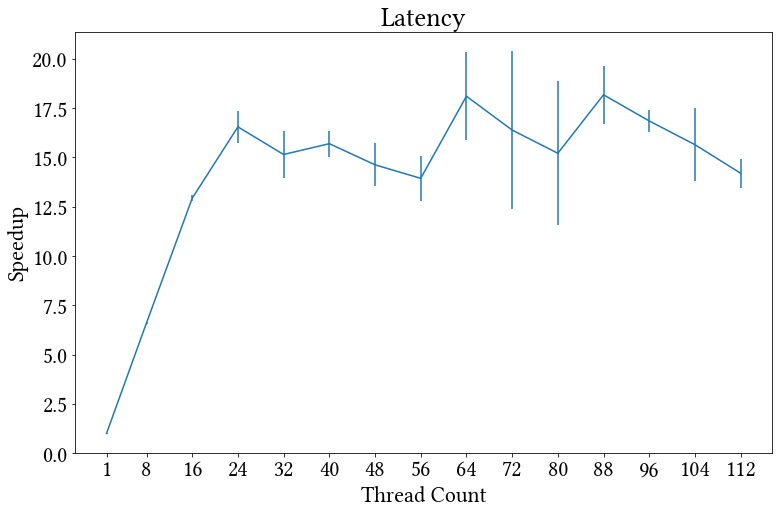

In [54]:
def plot_threaded_runtimes(thread_runtimes):
    nts = sorted(thread_runtimes.keys())
    
    avg_times = {}
    for nt in nts:
        avg_times[nt] = np.mean(thread_runtimes[nt])
    
    print('avg_times', avg_times)
    
    plt.rcParams.update({'font.size': 22})    
    speedup = [avg_times[1] / avg_times[nt] for nt in nts]
    errors = [np.std([avg_times[1] / x for x in thread_runtimes[nt]]) for nt in nts]
    times = np.log2([np.mean(thread_runtimes[nt])/1000. for nt in nts])

    # x_nts = np.log2(nts)
    x_nts = nts
    x_labels = nts
    
    print('speedup', speedup)
    
    #plt.plot(x_nts, times)
    plt.errorbar(x_nts, speedup,yerr=errors) #, label='Actual speedup')
    optimal_speedup = [nt for nt in nts]
    #plt.plot(x_nts, optimal_speedup), label='Optimal speedup')
        
    plt.xlabel('Thread Count')
    plt.xticks(x_nts, nts)
    
    #plt.legend()
    #plt.ylim((0,30))

    #y_ticks = [1, 2, 3, 4, 5]
    #y_labels = [2**y for y in y_ticks]
    #plt.yticks(y_ticks, y_labels)
    #plt.ylabel('Runtime (s)')
    plt.ylabel('Speedup')
    plt.title('Latency')
    
    fig = plt.gcf()
    fig.set_size_inches(12.5, 7.75)
    fig.savefig('cryptonets_runtime_vs_threads.png', dpi=300, bbox_inches='tight')
    
plot_threaded_runtimes(thread_runtimes)